In [64]:
from googletrans import Translator
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Amit\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
from gtts import gTTS
from IPython.display import Audio
import numpy as np
from matplotlib import pyplot as plt
import cv2
import fitz
import pandas as pd
from docx import Document


In [46]:

translator = Translator()

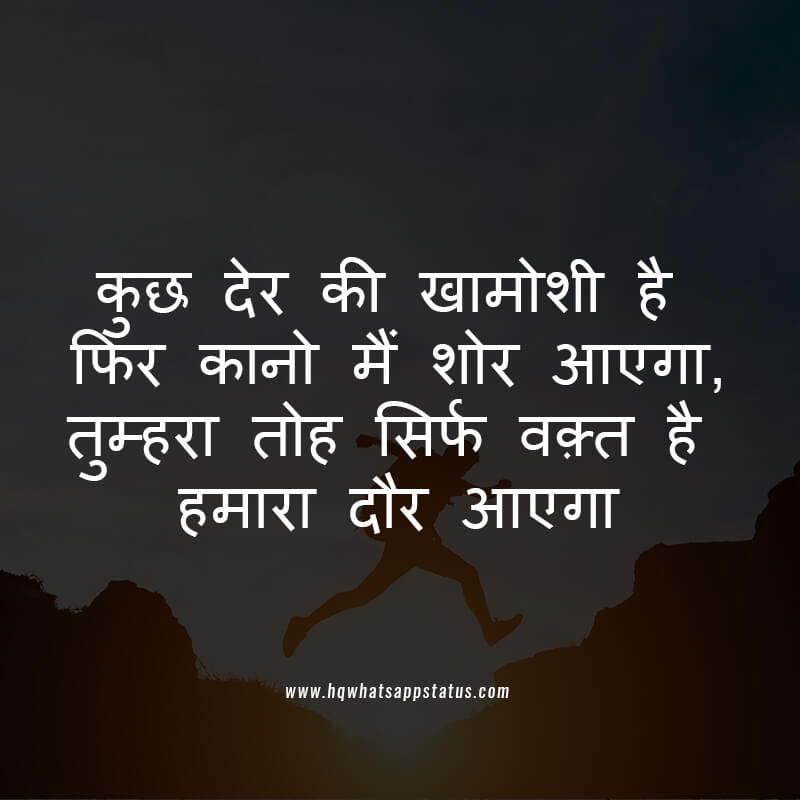

In [47]:
import PIL
from PIL import ImageDraw
im = PIL.Image.open("hindi-text-2.jpg")
im

In [48]:
text_cv = pytesseract.image_to_string(im,'hin')

In [49]:
print(text_cv)

कछ देर की खामोशी है

फिर कानो मैं शोर आएगा

तम्हरा तोह सिर्फ वक़्त है
हमारा दौर आएगा

॥॥र॥.॥(॥४॥959]]58/85.00॥



In [50]:
print(translator.detect(text_cv))

Detected(lang=hi, confidence=None)


In [51]:
text_en=translator.translate(text_cv, src='hi')
print(text_en.text)

Something is a long silence

Then the noise will come in the ears

Tamhara is just time
Our round will come

॥॥ 4.7 (॥ ४ ॥959] 58/85.00॥


In [52]:
ta_tts=gTTS(text_en.text)
ta_tts.save('./audio/trans.mp3')

In [53]:
Audio('./audio/trans.mp3' , autoplay=True)

In [54]:
ta_tts=gTTS(text_en.text, lang='ja')
ta_tts.save('trans.mp3')

In [55]:
Audio('trans.mp3' , autoplay=True)

In [56]:
text_hi=translator.translate(text_cv, src='hi',dest='en')
print(text_hi.text)

Something is a long silence

Then the noise will come in the ears

Tamhara is just time
Our round will come

॥॥ 4.7 (॥ ४ ॥959] 58/85.00॥


In [57]:
ta_tts_hi=gTTS(text_hi.text, lang='hi')
ta_tts_hi.save('trans_hi.mp3')

In [58]:
Audio('trans_hi.mp3' , autoplay=True)

In [59]:
text_fr=translator.translate(text_cv, src='ta',dest='fr')
print(text_fr.text)

कछ देर की खामोशी है

फिर कानो मैंर आएगा

तम्हरा तोह सिर्फ वक़्त है
हमारा दौर आएगा

॥॥ ॥॥॥॥॥॥॥॥॥॥॥॥॥॥॥॥॥


In [60]:
ta_tts_fr=gTTS(text_fr.text, lang='fr')
ta_tts_fr.save('trans_fr.mp3')

In [61]:
Audio('trans_fr.mp3' , autoplay=True)

In [62]:


class TextExtractor:
    def __init__(self):
        pass

    @staticmethod
    def extract_text_from_image(image_path, languages=['eng', 'mar']):
        # Read the image
        img = cv2.imread(image_path)

        # Grayscale conversion
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Thresholding
        _, im_bw = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)

        # Noise removal
        def noise_removal(image):
            kernel = np.ones((1, 1), np.uint8)
            image = cv2.dilate(image, kernel, iterations=1)
            kernel = np.ones((1, 1), np.uint8)
            image = cv2.erode(image, kernel, iterations=1)
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
            image = cv2.medianBlur(image, 3)
            return image

        no_noise = noise_removal(im_bw)

        # OCR with specified language
        ocr_result = pytesseract.image_to_string(no_noise, lang='+'.join(languages))

        return ocr_result

    @staticmethod
    def extract_text_from_pdf(pdf_path, languages=['eng', 'mar']):
        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        pdf_text = ''

        # Iterate through each page
        for page_number in range(pdf_document.page_count):
            page = pdf_document[page_number]

            # Extract text from the page
            pdf_text += page.get_text()

            # Extract images from the page and apply OCR
            for img_index, img in enumerate(page.get_images(full=True)):
                image_index = img[0]
                base_image = pdf_document.extract_image(image_index)
                image_bytes = base_image["image"]

                # Convert image bytes to OpenCV format
                np_image = np.frombuffer(image_bytes, dtype=np.uint8)
                img_cv2 = cv2.imdecode(np_image, flags=1)

                # OCR on the image
                image_ocr_result = pytesseract.image_to_string(img_cv2, lang='+'.join(languages))

                # Add image OCR result to the overall text
                pdf_text += f"\nImage {img_index + 1} OCR Result:\n{image_ocr_result}\n"

        pdf_document.close()

        return pdf_text

    @staticmethod
    def extract_text_from_doc(doc_path, languages=['eng', 'mar']):
        # Open the Word document
        doc = Document(doc_path)

        doc_text = ''

        # Iterate through paragraphs and tables
        for paragraph in doc.paragraphs:
            doc_text += paragraph.text + '\n'

        for table in doc.tables:
            for row in table.rows:
                for cell in row.cells:
                    doc_text += cell.text + '\t'

        # Extract images from the document and apply OCR
        for rel in doc.part.rels:
            if "image" in str(doc.part.rels[rel].target_ref):
                image_path = str(doc.part.rels[rel].target_part.blob)
                # OCR on the image
                image_ocr_result = TextExtractor.extract_text_from_image(image_path, languages)
                # Add image OCR result to the overall text
                doc_text += f"\nImage OCR Result:\n{image_ocr_result}\n"

        return doc_text

    def extract_text_from_image_or_pdf_or_doc(self, file_path, languages=['eng', 'mar']):
        # Check if the file is a PDF
        if file_path.lower().endswith(('.pdf')):
            # Extract text from PDF, including images
            pdf_text = self.extract_text_from_pdf(file_path, languages)
            return pdf_text
        elif file_path.lower().endswith(('.doc', '.docx')):
            # Extract text from Word document, including images
            doc_text = self.extract_text_from_doc(file_path, languages)
            return doc_text
        else:
            # Treat as an image file
            image_text = self.extract_text_from_image(file_path, languages)
            return image_text

# Example usage
text_extractor = TextExtractor()
result_text = text_extractor.extract_text_from_image_or_pdf_or_doc("Hindi2.jpg", languages=['hin'])
print(result_text)


सभी मनुष्यों को गोरव ओर अधिकारों के मामले में
जन्मजात स्वतन्त्रता और समानता प्राप्त है। उन्हें
बुद्धि ओर अन्तरात्मा की देन प्राप्त है ओर परस्पर
उन्हें भाईचारे के भाव से बताव करना चाहिए।




In [63]:
def extract_text_translate_and_generate_audio(result_text, source_language=('hi')):
# Instantiate the TextExtractor class
    

    # Translate the extracted text to English
    translator = Translator()
    translated_text = translator.translate(result_text, src=source_language, dest='en').text
    

    # Generate audio for the translated text
    tts = gTTS(translated_text, lang='en')
    tts.save('./audio/trans.mp3')    

    return  translated_text, './audio/trans.mp3'


translated_text, audio_file = extract_text_translate_and_generate_audio(result_text)

print("\nTranslated Text:")
print(translated_text)
print("\nAudio File:", audio_file)


Translated Text:
All humans in terms of gorav and rights
There is congenital freedom and equality.Them
Wisdom and conscience is attained and mutual
They should tell with brotherhood.

Audio File: ./audio/trans.mp3


In [65]:
img_cv=cv2.imread('Hindi2.jpg')
data = pytesseract.image_to_data(img_cv,'hin')
dataList = list(map(lambda x: x.split('\t'),data.split('\n')))
print(dataList)
df = pd.DataFrame(dataList[1:],columns=dataList[0])
df.dropna(inplace=True) # drop the missing in rows
col_int = ['level','page_num','block_num','par_num','line_num','word_num','left','top','width','height','conf']
df[col_int] = df[col_int].astype(float).astype(int)

[['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'], ['1', '1', '0', '0', '0', '0', '0', '0', '1050', '450', '-1', ''], ['2', '1', '1', '0', '0', '0', '47', '36', '963', '270', '-1', ''], ['3', '1', '1', '1', '0', '0', '47', '36', '963', '270', '-1', ''], ['4', '1', '1', '1', '1', '0', '48', '36', '962', '75', '-1', ''], ['5', '1', '1', '1', '1', '1', '48', '40', '86', '59', '96.936592', 'सभी'], ['5', '1', '1', '1', '1', '2', '149', '41', '134', '70', '96.490936', 'मनुष्यों'], ['5', '1', '1', '1', '1', '3', '327', '32', '48', '84', '96.078552', 'को'], ['5', '1', '1', '1', '1', '4', '365', '36', '104', '65', '96.430161', 'गौरव'], ['5', '1', '1', '1', '1', '5', '485', '36', '81', '65', '81.230896', 'ओर'], ['5', '1', '1', '1', '1', '6', '582', '41', '182', '60', '96.169304', 'अधिकारों'], ['5', '1', '1', '1', '1', '7', '778', '41', '39', '58', '97.011078', 'के'], ['5', '1', '1', '1', '1', '8', '831', '41', '127', '58', '9

In [66]:
image = img_cv.copy()
level = 'word'
for l,x,y,w,h,c,txt in df[['level','left','top','width','height','conf','text']].values:
    #print(l,x,y,w,h,c)
    if level == 'page':
        if l == 1:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,0),2)
        else:
            continue
            
    elif level == 'block':
        if l == 2:
            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            continue
    
    elif level == 'para':
        if l == 3:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        else:
            continue
    
    elif level == 'line':
        if l == 4:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
        else:
            continue
            
    elif level == 'word':
        if l == 5:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image,txt,(x,y),cv2.FONT_HERSHEY_PLAIN,1,(255,0,0),2)
        else:
            continue
            

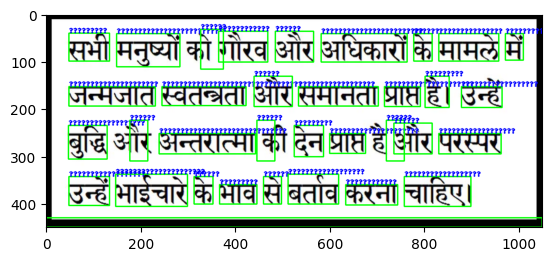

In [67]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
